## Classification of the issues reported from the Gandhinagar Smart City:
The complaints or grievance reported by the residents of Gandhinagar city, Gujarat, through the mobile applications are used to classify its category or labeling according to type of complaints registered. Thus it can be use to classify the complaints 


## Preprocessing

In [11]:
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import joblib
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import pandas as pd
import re
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

Fixed the issues with json packets 

In [2]:
filename = "gandhinagar_civic.json"

with open(filename, 'r') as file:
    json_data = file.read()

json_list = json.loads(json_data)

df = pd.DataFrame(json_list)
        
#df.to_csv("civic_issues.csv")


In [23]:
df = pd.read_csv("civic_issues.csv")

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7902 entries, 0 to 7901
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           7902 non-null   int64 
 1   comments             7902 non-null   object
 2   address              7902 non-null   object
 3   resolutionStatus     7902 non-null   object
 4   reportID             7902 non-null   object
 5   id                   7902 non-null   object
 6   wardID               7902 non-null   object
 7   zoneName             7902 non-null   object
 8   observationDateTime  7902 non-null   object
 9   category             7845 non-null   object
 10  department           7902 non-null   object
 11  title                7902 non-null   object
dtypes: int64(1), object(11)
memory usage: 740.9+ KB


In [25]:
df.head()

,Unnamed: 0,comments,address,resolutionStatus,reportID,id,wardID,zoneName,observationDateTime,category,department,title
0,0,['At Sector 21 from Plot No. 576/1 to 578/2 Fo...,Sector 21,Open,TT12287,b12c46d6-36bb-4aff-a50d-ad9fefaffc06,6,Middle Zone,2023-06-30T00:16:28+05:30,Compiant,Engineering (Civil) Department,Water Issue
1,1,['Plot No. 156/2 Surynarayan Society Sec-25 Th...,Sector 25,Open,TT12288,b12c46d6-36bb-4aff-a50d-ad9fefaffc06,1,North Zone,2023-06-30T07:13:43+05:30,Compiant,Engineering (Civil) Department,potholes on the road
2,2,['I live in housing board colony at Gandhinaga...,Sector 24,Open,TT12289,b12c46d6-36bb-4aff-a50d-ad9fefaffc06,3,North Zone,2023-06-30T08:43:20+05:30,Compiant,Engineering (Civil) Department,potholes on the road
3,3,['Plot No.537 Line Sec-26 Door To Door Garbage...,Sector 26,Open,TT12290,b12c46d6-36bb-4aff-a50d-ad9fefaffc06,1,North Zone,2023-06-30T08:45:32+05:30,Compiant,Sanitation Department,Garbage Collection
4,4,['It is unpleasure to inform u that being smar...,Sector 3,Open,TT12291,b12c46d6-36bb-4aff-a50d-ad9fefaffc06,9,South Zone,2023-06-30T08:49:22+05:30,Compiant,Sanitation Department,Cleaning Issue


In [13]:
df.drop(columns = ["id","Unnamed: 0","observationDateTime","wardID","zoneName","category","resolutionStatus","address"],inplace = True)

In [5]:
df.duplicated().sum()

149

In [14]:
df.drop_duplicates(inplace = True)

### Tokenisation

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [17]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/iudx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iudx/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/iudx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
df.head()

,comments,reportID,department,title
0,['At Sector 21 from Plot No. 576/1 to 578/2 Fo...,TT12287,Engineering (Civil) Department,Water Issue
1,['Plot No. 156/2 Surynarayan Society Sec-25 Th...,TT12288,Engineering (Civil) Department,potholes on the road
2,['I live in housing board colony at Gandhinaga...,TT12289,Engineering (Civil) Department,potholes on the road
3,['Plot No.537 Line Sec-26 Door To Door Garbage...,TT12290,Sanitation Department,Garbage Collection
4,['It is unpleasure to inform u that being smar...,TT12291,Sanitation Department,Cleaning Issue


Firstly the stop words or uninformative words are removed from the comments using stopwords function and then converted into token.
The WordNetLemmatizer is used to reduce words to their base or root form, which gives proper or meaningful words in the comments instead of using stemming that gives base words which may not have proper meaning

In [18]:
def preprocess_text(text):
    
    text = re.sub(r'^[^.]*\.', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'\W', ' ', text) 
    text = text.lower()  
    tokens = nltk.word_tokenize(text)  
    tokens = [word for word in tokens if word not in stopwords.words('english')]  
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens] 
    return ' '.join(tokens)

df['processed_comments'] = df['comments'].apply(preprocess_text)

print(df[['comments', 'processed_comments']])

                                               comments  \
0     ['At Sector 21 from Plot No. 576/1 to 578/2 Fo...   
1     ['Plot No. 156/2 Surynarayan Society Sec-25 Th...   
2     ['I live in housing board colony at Gandhinaga...   
3     ['Plot No.537 Line Sec-26 Door To Door Garbage...   
4     ['It is unpleasure to inform u that being smar...   
...                                                 ...   
7897  ['Bhat Karnavati Infinity Living Service Road ...   
7898  ['Dholakuva Gam Ambe Mata Temple ,Shiv Shakti ...   
7899  ['Por Gam Dr.Baba Saheb Ambedkar Hall Near,The...   
7900  ['Zundal-Tragad Road  Cross Road Pancham Penta...   
7901  ['Kolavada Darbar Bhagol Gram Panchayat Galli ...   

                                     processed_comments  
0     water pipe line team came dig ground cyclone d...  
1     surynarayan society sec pothole road send repa...  
2     nwhenever monsoon season flooded causing lot p...  
3          line sec door door garbage van come last day  
4

In [11]:
df['title'].value_counts()

Tree Cutting                                   960
Cleaning Issue                                 895
Street Light Issue                             835
Garbage Collection                             780
Drainage Overflow                              572
Road Repairing                                 521
Water Issue                                    501
Stray Dog                                      368
Dead Animal                                    343
Drainage Issue                                 291
potholes on the road                           266
Daban issue                                    249
Regarding fogging performance                  213
Water line leakage                             206
Storm water (flood of water)                   131
Road Cleaning                                  109
Stray cattle                                   100
Water pressure problem                          66
TAX Related                                     42
Regarding timely supply of wate

## Naive Bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['processed_comments'], df['title'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [112]:
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions)

joblib.dump(model, 'naive_bayes_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')


Accuracy: 76.22%
                             Actual                      Predicted
4914             Street Light Issue             Street Light Issue
4901                 Drainage Issue              Drainage Overflow
2301                 Cleaning Issue                 Cleaning Issue
6954             Street Light Issue             Street Light Issue
3529                    Dead Animal                    Dead Animal
...                             ...                            ...
4112                 Cleaning Issue                 Cleaning Issue
1410           potholes on the road                 Road Repairing
4294           potholes on the road                 Road Repairing
3139                   Tree Cutting                   Tree Cutting
889   Regarding fogging performance  Regarding fogging performance

[1581 rows x 2 columns]


## Load the model and the vectorizer


In [9]:
loaded_model = joblib.load('naive_bayes_model.pkl')
loaded_vectorizer = joblib.load('vectorizer.pkl')

def preprocess_text(text):
    #text = re.sub(r'^[^.]*\.', '', text)
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = text.lower()  
    return ' '.join(text.split())


new_comments = ["There is a damaged electric post at 5th Avenue", "mosquito issue"]

new_comments_processed = list(map(preprocess_text,new_comments))

print(new_comments_processed)
new_comments_vectorized = loaded_vectorizer.transform(new_comments_processed)

new_predictions = loaded_model.predict(new_comments_vectorized)

for comment, label in zip(new_comments, new_predictions):
    print(f"Comment: {comment}")
    print(f"Predicted Label: {label}")

['there is a damaged electric post at th avenue', 'mosquito issue']
Comment: There is a damaged electric post at 5th Avenue
Predicted Label: Tree Cutting
Comment: mosquito issue
Predicted Label: Regarding fogging performance


## Support Vector Machine  Classifier

In [13]:
svm_model = svm.SVC(kernel='rbf', probability=True)

parameters = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]}
grid_search = GridSearchCV(svm_model, parameters, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters: {'C': 10, 'gamma': 0.1}
                                             precision    recall  f1-score   support

                                      Admin       0.00      0.00      0.00         1
                               Animal Issue       0.00      0.00      0.00         2
                           Buwa on the road       0.00      0.00      0.00         1
                             Cleaning Issue       0.66      0.59      0.62       180
                 Cleaning of public toilets       0.00      0.00      0.00         1
                       Common Plot cleaning       0.00      0.00      0.00         1
                  Complaint about fire call       0.00      0.00      0.00         2
               Complaints of polluted water       0.00      0.00      0.00         2
                                Daban issue       0.70      0.43      0.53        53
                                Dead Animal       0.98      0.84      0.90        67
                       

['/home/iudx/pari/python/nlp/civic_issues_gandhinagar/vectorizer_svm1.joblib']

## Load the SVM saved model

In [25]:
loaded_model = joblib.load('svm_best_model.joblib')

loaded_vectorizer = joblib.load('vectorizer_svm.joblib')

new_comments = ["There is a damaged electric post at 5th Avenue", "mosquito issue"]

new_comments_processed = list(map(preprocess_text,new_comments))

print(new_comments_processed)

new_comments_vectorized = loaded_vectorizer.transform(new_comments_processed)

new_predictions = loaded_model.predict(new_comments_vectorized)

for comment, label in zip(new_comments, new_predictions):
    print(f"Comment: {comment}")
    print(f"Predicted Label: {label}")

['damaged electric post th avenue', 'mosquito issue']
Comment: There is a damaged electric post at 5th Avenue
Predicted Label: Cleaning Issue
Comment: mosquito issue
Predicted Label: Regarding fogging performance


## Using BERT Model

### Load the BERT tokenizer

In [25]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(df, tokenizer, max_length=128):
    return tokenizer(
        list(df),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_encodings = tokenize_data(X_train, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)


In [27]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

label2id = {label: idx for idx, label in enumerate(df['title'].unique())}
id2label = {idx: label for label, idx in label2id.items()}

y_train = y_train.map(label2id)
y_test = y_test.map(label2id)

train_dataset = CustomDataset(train_encodings, y_train.values)
test_dataset = CustomDataset(test_encodings, y_test.values)

In [28]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['title'].unique()))

training_args = TrainingArguments(
    output_dir='results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='logs',
    logging_steps=10,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=test_dataset            
)

trainer.train()

trainer.evaluate()

Step,Training Loss
10,3.779200
20,3.785400
30,3.686900
40,3.769400
50,3.695700
60,3.637900
70,3.515800
80,3.406300
90,3.419600
100,3.252500


{'eval_loss': 0.5204839110374451,
 'eval_runtime': 218.5979,
 'eval_samples_per_second': 7.232,
 'eval_steps_per_second': 0.906,
 'epoch': 3.0}

In [33]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

joblib.dump(id2label, 'label_encoder.pkl')
trainer.save_model("saved_model")

['/home/iudx/pari/python/nlp/label_encoder.pkl']

In [34]:
label_encoder = joblib.load('label_encoder.pkl')

In [83]:
model = BertForSequenceClassification.from_pretrained("saved_model")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

id2label = {idx: label for label, idx in label2id.items()}

def preprocess_text(text):
    #text = re.sub(r'^[^.]*\.', '', text)
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = text.lower()  
    return ' '.join(text.split())

new_comments = ["Fear of Malaria"]

new_comments_series = pd.Series(new_comments)

new_comments_processed = new_comments_series.apply(preprocess_text).tolist()

print(new_comments_processed)

new_encodings = tokenizer(
    new_comments_processed,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

model.eval()

with torch.no_grad():
    outputs = model(**new_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

predicted_labels = [id2label[pred.item()] for pred in predictions]

for comment, label in zip(new_comments_processed, predicted_labels):
    print(f"Comment: {comment}")
    print(f"Predicted Label: {label}")
    print()

['fear of malaria']
Comment: fear of malaria
Predicted Label: Regarding fogging performance



In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [40]:
def get_predictions_and_labels(trainer, dataset):
    predictions = trainer.predict(dataset)
    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids
    return preds, labels

preds, labels = get_predictions_and_labels(trainer, test_dataset)

decoded_preds = [id2label[pred] for pred in preds]
decoded_labels = [id2label[label] for label in labels]

from sklearn.metrics import classification_report
print(classification_report(decoded_labels, decoded_preds))

                                  precision    recall  f1-score   support

                           Admin       0.00      0.00      0.00         2
                    Animal Issue       0.00      0.00      0.00         3
                  Cleaning Issue       0.77      0.95      0.85       185
      Cleaning of public toilets       0.00      0.00      0.00         1
            Common Plot cleaning       0.00      0.00      0.00         2
    Complaints of polluted water       1.00      0.25      0.40         4
                     Daban issue       0.86      0.88      0.87        50
                     Dead Animal       0.99      0.97      0.98        72
                  Drainage Issue       0.76      0.56      0.64        70
               Drainage Overflow       0.83      0.96      0.89       120
              Garbage Collection       0.99      0.89      0.94       162
                    Garden Light       0.00      0.00      0.00         2
              Garden Maintenance     

The dataset contains the imbalance data, here there are 45 titles ie, 45 different classes, and there are some classes with extremly low frequency, hence the dataset shall be resampled with the adequate minority classes to imporve the performance or accuracy of the model. Here the k-nearest_neighbor is used in the SMOTE, where the minium k value is an integer, while in this case some classes have the frequnecy nearer to 1, thus resampling only with SMOTE is not possible. So the SMOTE is combined with random sampling to over sample the minority classes in this dataset.


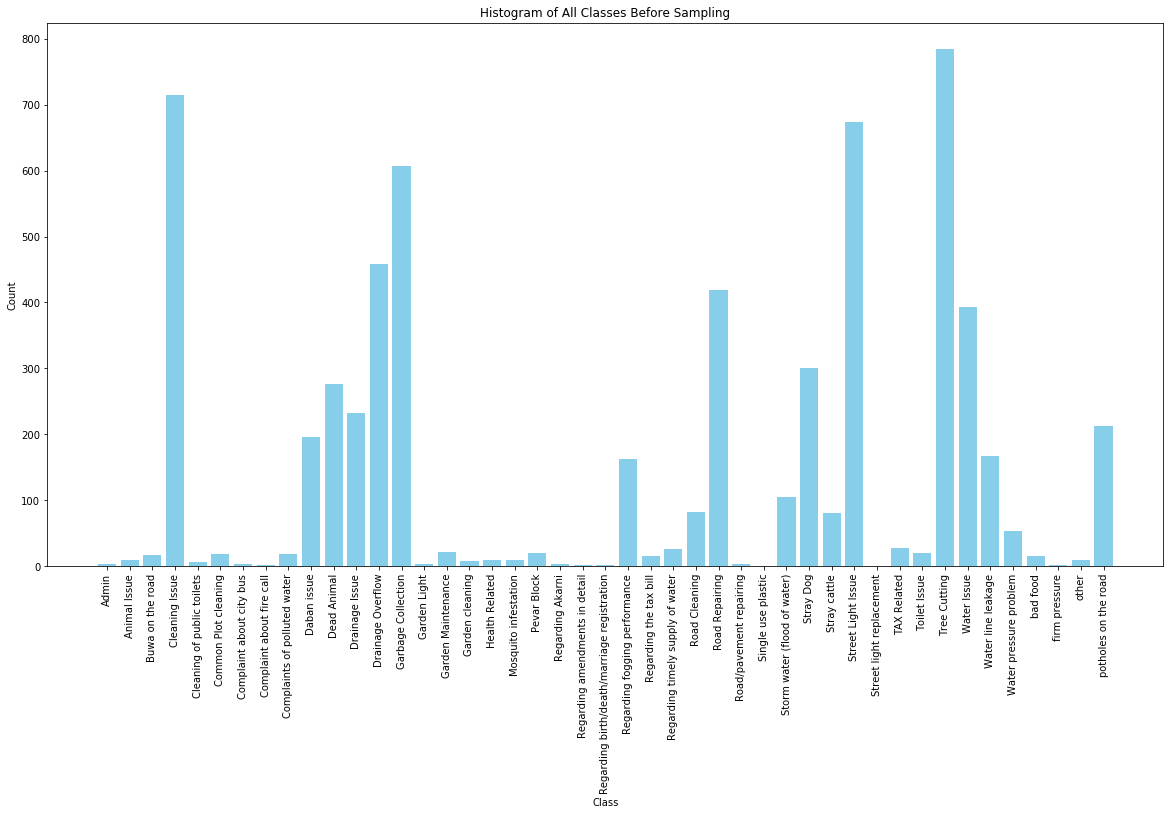

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter(y_train)

class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index').reset_index()
class_counts_df.columns = ['Class', 'Count']

class_counts_df = class_counts_df.sort_values(by='Class')

plt.figure(figsize=(20, 10))
plt.bar(class_counts_df['Class'], class_counts_df['Count'], color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Histogram of All Classes Before Sampling')
plt.xticks(rotation=90)
plt.show()


Before SMOTE: Counter({'Tree Cutting': 785, 'Cleaning Issue': 715, 'Street Light Issue': 673, 'Garbage Collection': 607, 'Drainage Overflow': 459, 'Road Repairing': 419, 'Water Issue': 393, 'Stray Dog': 300, 'Dead Animal': 276, 'Drainage Issue': 233, 'potholes on the road': 212, 'Daban issue': 196, 'Water line leakage': 167, 'Regarding fogging performance': 163, 'Storm water (flood of water)': 105, 'Road Cleaning': 82, 'Stray cattle': 81, 'Water pressure problem': 54, 'TAX Related': 27, 'Regarding timely supply of water': 26, 'Garden Maintenance': 22, 'Toilet Issue': 20, 'Pevar Block': 20, 'Common Plot cleaning': 19, 'Complaints of polluted water': 18, 'Buwa on the road': 17, 'bad food': 16, 'Regarding the tax bill': 16, 'Mosquito infestation': 10, 'Health Related': 10, 'other': 10, 'Animal Issue': 9, 'Garden cleaning': 8, 'Cleaning of public toilets': 7, 'Complaint about city bus': 4, 'Road/pavement repairing': 4, 'Garden Light': 3, 'Regarding Akarni': 3, 'Admin': 3, 'Regarding birth/

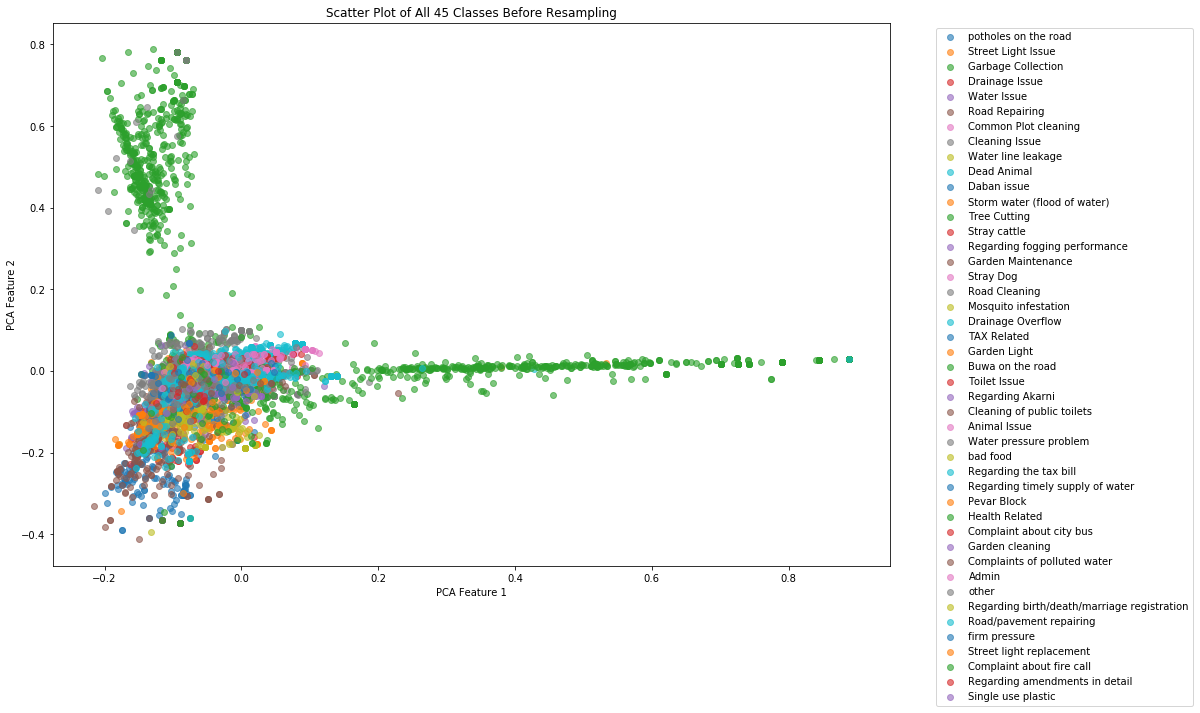

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(df['comments'], df['title'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=10000)  
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Before SMOTE:", Counter(y_train))

pca = PCA(n_components=2)
X_train_pca_before = pca.fit_transform(X_train_tfidf.toarray())

plt.figure(figsize=(15, 10))
counter = Counter(y_train)
for label, _ in counter.items():
    row_ix = np.where(y_train == label)[0]
    plt.scatter(X_train_pca_before[row_ix, 0], X_train_pca_before[row_ix, 1], label=str(label), alpha=0.6)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Scatter Plot of All 45 Classes Before Resampling")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()

In [22]:
class_counts = df['title'].value_counts()
minority_classes = class_counts[class_counts < 2].index.tolist()

df = df[~df['title'].isin(minority_classes)]


vectorizer = TfidfVectorizer(max_features=10000)  
X_tfidf = vectorizer.fit_transform(df['comments_processed'])
y = df['title']

class_counts = df['title'].value_counts()

sampling_strategy = {}
for label, count in class_counts.items():
    if count < 100:
        target_count = min(max(100, count), 200)
        sampling_strategy[label] = target_count

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42,k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
y_resampled.value_counts()

Tree Cutting                                   960
Cleaning Issue                                 895
Street Light Issue                             835
Garbage Collection                             780
Drainage Overflow                              572
Road Repairing                                 521
Water Issue                                    501
Stray Dog                                      368
Dead Animal                                    343
Drainage Issue                                 291
potholes on the road                           266
Daban issue                                    249
Regarding fogging performance                  213
Water line leakage                             206
Storm water (flood of water)                   131
Road Cleaning                                  109
Complaints of polluted water                   100
Road/pavement repairing                        100
Common Plot cleaning                           100
Garden cleaning                

## Resampling of minority classes using the Random Over Sampling Technique  for the LSTM model

In [202]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from sklearn.metrics import classification_report
import numpy as np


class_counts = df['title'].value_counts()
valid_classes = class_counts[class_counts >= 2].index.tolist()
df_filtered = df[df['title'].isin(valid_classes)]

X = df_filtered['processed_comments']
y = df_filtered['title']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer.fit_transform(X)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_tfidf, y_encoded)

class_counts_resampled = pd.Series(y_resampled).value_counts()
sampling_strategy = {label: min(200, count) for label, count in class_counts_resampled.items() if count < 100}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

X_resampled_text = vectorizer.inverse_transform(X_resampled)

X_resampled_text = [" ".join(text) for text in X_resampled_text]

max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_resampled_text)

X_seq = tokenizer.texts_to_sequences(X_resampled_text)
X_pad = pad_sequences(X_seq, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_resampled, test_size=0.2, random_state=42)

embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(np.unique(y_resampled)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 64
epochs = 5

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


Epoch 1/5
423/423 [==============================] - 40s 89ms/step - loss: 1.4253 - accuracy: 0.6450 - val_loss: 0.4124 - val_accuracy: 0.8806
Epoch 2/5
423/423 [==============================] - 40s 95ms/step - loss: 0.3523 - accuracy: 0.8956 - val_loss: 0.2482 - val_accuracy: 0.9207
Epoch 3/5
423/423 [==============================] - 40s 95ms/step - loss: 0.2417 - accuracy: 0.9268 - val_loss: 0.2115 - val_accuracy: 0.9370
Epoch 4/5
423/423 [==============================] - 40s 95ms/step - loss: 0.1920 - accuracy: 0.9387 - val_loss: 0.1872 - val_accuracy: 0.9417
Epoch 5/5
264/264 [==============================] - 5s 17ms/step
                                             precision    recall  f1-score   support

                                      Admin       1.00      1.00      1.00       192
                               Animal Issue       0.97      1.00      0.98       194
                           Buwa on the road       0.95      0.84      0.89       189
                     

In [203]:
model.save('lstm_model.h5')
joblib.dump(tokenizer, 'lstm_tokenizer.pkl')
joblib.dump(label_encoder, 'lstm_label_encoder.pkl')

['/home/iudx/pari/python/nlp/civic_issues_gandhinagar/lstm_label_encoder.pkl']

In [9]:
from keras.models import load_model
import joblib
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

model = load_model('lstm_model.h5')
tokenizer = joblib.load('lstm_tokenizer.pkl')
label_encoder = joblib.load('lstm_label_encoder.pkl')

new_comments = ["Tree branches on the electric post that needs to be cleaned"]
new_comments_seq = tokenizer.texts_to_sequences(new_comments)
new_comments_pad = pad_sequences(new_comments_seq, maxlen=100)

predictions = model.predict(new_comments_pad)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

for comment, label in zip(new_comments, predicted_labels):
    print(f"Comment: {comment}\nPredicted Label: {label}")

1/1 [==============================] - 0s 141ms/step
Comment: Tree branches on the electric post that needs to be cleaned
Predicted Label: Tree Cutting


## Naive Bayes using SMOTE Oversampling Technique

In [21]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import uniform
import joblib  


class_counts = df['title'].value_counts()
valid_classes = class_counts[class_counts >= 2].index.tolist()
df = df[df['title'].isin(valid_classes)]

def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'\W', ' ', text)  
    text = re.sub(r'\s+', ' ', text)  
    text = text.lower().strip()  
    return text

df['comments_processed'] = df['comments'].apply(preprocess_text)

vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_tfidf = vectorizer.fit_transform(df['comments_processed'])
y = df['title']

sampling_strategy = {}
for label, count in class_counts.items():
    if count < 100:
        target_count = min(max(100, count), 200)
        sampling_strategy[label] = target_count

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

clf = MultinomialNB()

param_grid = {
    'alpha': uniform(0.1, 2.0) 
}

random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)

best_clf = random_search.best_estimator_
joblib.dump(best_clf, 'naive_bayes_hp_model.pkl')  

y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))


Best parameters found:  {'alpha': 0.1110442342472048}
Accuracy: 0.83
                                             precision    recall  f1-score   support

                                      Admin       1.00      1.00      1.00        20
                               Animal Issue       0.92      0.60      0.73        20
                           Buwa on the road       0.90      0.45      0.60        20
                             Cleaning Issue       0.67      0.88      0.76       179
                 Cleaning of public toilets       1.00      1.00      1.00        20
                       Common Plot cleaning       1.00      0.10      0.18        20
                   Complaint about city bus       1.00      1.00      1.00        20
                  Complaint about fire call       1.00      1.00      1.00        20
               Complaints of polluted water       0.95      0.90      0.92        20
                                Daban issue       0.88      0.70      0.78      

In [28]:
new_comments = [
    "Unable to get birth certificate for one month.",
    "There is a drainage issue.",
    "Please clean the garbage near the park.",
    "The lights are not working on 5th Avenue, and we are not able to go out in the evening"
]

new_comments_processed = [preprocess_text(comment) for comment in new_comments]

X_new_tfidf = vectorizer.transform(new_comments_processed)

new_comments_pred = best_clf.predict(X_new_tfidf)


for comment, label in zip(new_comments, new_comments_pred):
    print(f"Comment: {comment}")
    print(f"Predicted Label: {label}")
    print()


Comment: Unable to get birth certificate for one month.
Predicted Label: Regarding birth/death/marriage registration

Comment: There is a drainage issue.
Predicted Label: Drainage Issue

Comment: Please clean the garbage near the park.
Predicted Label: Cleaning Issue

Comment: The lights are not working on 5th Avenue. and we are not able to go out in the evening
Predicted Label: Street Light Issue



# Inference:
The dataset consisted of imbalanced classes, which were initially used to train the Naive Bayes and SVM models, resulting in less accurate outcomes: SVM achieved 61% accuracy, BERT model achieved 87% accuracy and Naive Bayes achieved 76%. Therefore, I oversampled the dataset to help the models generalize better on the data. I used multiple models and different oversampling techniques. As a result, the random oversampling technique with the LSTM model achieved an accuracy of 95%, which was chosen for the final model.